In [289]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from riskfolio import Portfolio
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas_market_calendars as mcal
from datetime import datetime, timedelta
from pathlib import Path
import seaborn as sns
from scipy.stats import skew
import scipy.optimize as sco
from scipy.optimize import minimize
from scipy.stats import norm

LOADING DATA

In [290]:
def load_price_data(
    start_date='2020-01-01',
    end_date=datetime.today(),
    assets=["Stock", "Bond", "Commodity"],  # or use "All" for everything
    path_stock="data\\master_stock_data.csv",
    path_bond="data\\master_bond_etf_data.csv",
    path_commodity="data\\master_commodity_etf_data.csv"
):
    if end_date is None:
        end_date = datetime.now()

    # Convert to Timestamps
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    def load_and_filter(filepath, asset_type):
        df = pd.read_csv(filepath, parse_dates=['Date'])
        df = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]
        df['AssetType'] = asset_type
        return df

    # Normalize asset input
    if isinstance(assets, str):
        assets = [assets]
    if "All" in assets:
        assets = ["Stock", "Bond", "Commodity"]

    combined = []

    if "Stock" in assets:
        combined.append(load_and_filter(path_stock, "Stock"))

    if "Bond" in assets:
        try:
            combined.append(load_and_filter(path_bond, "Bond"))
        except FileNotFoundError:
            print(f"Warning: {path_bond} not found. Skipping Bond data.")

    if "Commodity" in assets:
        try:
            combined.append(load_and_filter(path_commodity, "Commodity"))
        except FileNotFoundError:
            print(f"Warning: {path_commodity} not found. Skipping Commodity data.")

    if not combined:
        raise ValueError("No valid asset types selected or no files found.")

    final_df = pd.concat(combined, ignore_index=True)
    final_df.sort_values(by="Date", inplace=True)

    return final_df


ASSET SELECTION

In [291]:
def filter_by_var(price_df, confidence_level=0.95, var_threshold=-0.05, lookback=252, method='historical'):
    if 'Date' not in price_df.columns or 'Symbol' not in price_df.columns or 'Close' not in price_df.columns:
        raise ValueError("Input DataFrame must contain 'Date', 'Symbol', and 'Close' columns.")

    price_df = price_df.sort_values(['Symbol', 'Date'])

    returns = price_df.groupby('Symbol')['Close'].apply(lambda x: x.pct_change()).dropna()
    var_series = {}

    for symbol, r in returns.groupby('Symbol'):
        r = r.iloc[-lookback:]
        if len(r) == 0:
            continue
        if method == 'historical':
            var = np.percentile(r, (1 - confidence_level) * 100)
        elif method == 'parametric':
            mu = r.mean()
            sigma = r.std()
            z = norm.ppf(1 - confidence_level)
            var = mu + z * sigma
        else:
            raise ValueError("Method must be 'historical' or 'parametric'.")
        var_series[symbol] = var

    var_df = pd.Series(var_series)
    return var_df[var_df >= var_threshold].index.tolist()



def filter_by_volatility(price_df, window=20, min_vol=0.005, max_vol=0.05):
    if 'Date' not in price_df.columns or 'Symbol' not in price_df.columns or 'Close' not in price_df.columns:
        raise ValueError("Input DataFrame must contain 'Date', 'Symbol', and 'Close' columns.")

    # Sort by Symbol and Date to ensure correct time order within each symbol
    price_df = price_df.sort_values(['Symbol', 'Date'])

    # Calculate daily returns per symbol
    returns = price_df.groupby('Symbol')['Close'].apply(lambda x: x.pct_change()).dropna()

    # Calculate rolling volatility (std dev) per symbol
    rolling_vol = returns.groupby('Symbol').rolling(window).std().reset_index(level=0, drop=True)

    # Get the last rolling volatility value for each symbol
    last_vol = rolling_vol.groupby('Symbol').last()

    # Filter symbols whose volatility falls within the desired range
    filtered = last_vol[(last_vol >= min_vol) & (last_vol <= max_vol)]

    return filtered.index.tolist()



def filter_by_correlation(price_df, corr_threshold=0.3):
    df = price_df.copy()
    if 'Date' not in df.columns or 'Symbol' not in df.columns or 'Close' not in df.columns:
        raise ValueError("Input DataFrame must contain 'Date', 'Symbol', and 'Close' columns.")
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    returns = df.pivot(index='Date', columns='Symbol', values='Close').pct_change().dropna()
    corr_matrix = returns.corr()

    selected = []
    for asset in corr_matrix.columns:
        if all(abs(corr_matrix.loc[asset, other]) < corr_threshold for other in selected):
            selected.append(asset)

    return selected, corr_matrix.loc[selected, selected]


def select_assets_by_sharpe(price_df, risk_free_rate=0.0, top_n=None, min_sharpe=None):
    df = price_df.copy()
    if 'Date' not in df.columns or 'Symbol' not in df.columns or 'Close' not in df.columns:
        raise ValueError("Input DataFrame must contain 'Date', 'Symbol', and 'Close' columns.")
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    df_wide = df.pivot(index='Date', columns='Symbol', values='Close')
    returns = df_wide.pct_change().dropna()

    rf_daily = (1 + risk_free_rate) ** (1/252) - 1

    sharpe_data = []
    for asset in returns.columns:
        mean_ret = returns[asset].mean()
        std_dev = returns[asset].std()
        sharpe = (mean_ret - rf_daily) / std_dev if std_dev and not np.isnan(std_dev) else np.nan
        sharpe_data.append({
            'asset': asset,
            'mean_return': mean_ret,
            'std_dev': std_dev,
            'sharpe_ratio': sharpe
        })

    sharpe_df = pd.DataFrame(sharpe_data).dropna().set_index('asset').sort_values('sharpe_ratio', ascending=False)

    if top_n is not None:
        selected_assets = sharpe_df.head(top_n).index.tolist()
    elif min_sharpe is not None:
        selected_assets = sharpe_df[sharpe_df['sharpe_ratio'] >= min_sharpe].index.tolist()
    else:
        selected_assets = sharpe_df.index.tolist()

    return sharpe_df, selected_assets



In [292]:
df = load_price_data(end_date='2025-01-01')

safe_assets = filter_by_var(df, confidence_level=0.95, var_threshold=-0.02, lookback=252, method='historical')
price_df = df[df['Symbol'].isin(safe_assets)]

# Step 2: Filter by volatility
stable_assets = filter_by_volatility(price_df=price_df)
price_df = price_df[price_df['Symbol'].isin(stable_assets)]

# Step 4: Filter by correlation
final_assets, corr_matrix = filter_by_correlation(price_df, corr_threshold=0.9)
final_price_df = price_df[price_df['Symbol'].isin(final_assets)]


In [293]:
len(safe_assets) ,len(stable_assets) ,len(final_assets)

(204, 187, 182)

BASE STRATEGY 

In [ ]:
def ewma_momentum_signals(price_df, span=60, threshold=0.001, min_days_above_thresh=5):
    df = price_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Date', 'Symbol'])
    df = df.set_index('Date')

    prices = df.pivot(columns="Symbol", values="Close")

    shifted_prices = prices.shift(1)
    log_returns = np.log(prices / shifted_prices)

    momentum_df = log_returns.ewm(span=span, adjust=False).mean()

    pos_momentum = (momentum_df > threshold).astype(int)
    neg_momentum = (momentum_df < -threshold).astype(int)

    pos_count = pos_momentum.rolling(window=span).sum()
    neg_count = neg_momentum.rolling(window=span).sum()

    long_signal = (pos_count >= min_days_above_thresh).astype(int)
    short_signal = (neg_count >= min_days_above_thresh).astype(int)

    # Clean signals: if both long and short active, set to 0 (neutral)
    signal_df = long_signal - short_signal
    conflict_mask = (long_signal == 1) & (short_signal == 1)
    signal_df[conflict_mask] = 0

    return momentum_df, signal_df, long_signal


def simple_moving_average(price_df, short_window=50, long_window=200):
    """
    Compute SMA signals avoiding lookahead bias (uses previous day's moving averages).
    Returns wide-format signal DataFrame.

    Args:
        price_df (pd.DataFrame): Must contain 'Date', 'Symbol', 'Close'.
        short_window (int): Window for short SMA.
        long_window (int): Window for long SMA.

    Returns:
        sma_short (pd.DataFrame): Short window SMA (shifted by 1 day).
        sma_long (pd.DataFrame): Long window SMA (shifted by 1 day).
        signal_df (pd.DataFrame): Signals: 1 for long, -1 for short, 0 for neutral.
    """

    # Check required columns
    required_cols = {'Date', 'Symbol', 'Close'}
    if not required_cols.issubset(price_df.columns):
        raise ValueError(f"Input DataFrame must contain {required_cols}")

    # Sort by Date and Symbol
    price_df_sorted = price_df.sort_values(by=['Date', 'Symbol']).copy()

    # Pivot to wide format with Date index and Symbol columns
    prices = price_df_sorted.pivot(index='Date', columns='Symbol', values='Close')

    # Calculate rolling SMAs and shift by 1 day to avoid lookahead bias
    sma_short = prices.rolling(window=short_window).mean().shift(1)
    sma_long = prices.rolling(window=long_window).mean().shift(1)

    # Initialize signals with 0
    signal_df = pd.DataFrame(0, index=prices.index, columns=prices.columns)

    # Generate signals
    signal_df[sma_short > sma_long] = 1
    signal_df[sma_short < sma_long] = -1
    signal_df = signal_df.ffill().fillna(0)

    
    return signal_df

WEIGHTING PORTFOLIO

In [295]:
def regularized_risk_parity_weights(df, lookback=60, price_column="Close", epsilon=1e-4, min_weight=1e-3, l2_penalty=1e-2):
    """
    Compute regularized risk parity weights using Ledoit-Wolf shrinkage and L2 penalty.

    Args:
        df (pd.DataFrame): Long format with ['Date', 'Symbol', price_column].
        lookback (int): Rolling window length.
        price_column (str): Column to use for prices.
        epsilon (float): Numerical stability floor.
        min_weight (float): Lower bound for weights.
        l2_penalty (float): L2 penalty weight for regularization.

    Returns:
        pd.DataFrame: Risk parity weights (Date index, Symbols as columns).
    """
    df = df.reset_index() if df.index.name == 'Date' else df.copy()
    price_df = df.pivot(index='Date', columns='Symbol', values=price_column).sort_index()
    returns = price_df.pct_change()

    def shrinked_cov(window):
        lw = LedoitWolf()
        return pd.DataFrame(lw.fit(window.dropna()).covariance_, 
                            index=window.columns, columns=window.columns)

    def get_regularized_rp_weights(cov):
        n = len(cov)
        assets = cov.columns
        x0 = np.ones(n) / n

        def portfolio_risk(w):
            return np.sqrt(w.T @ cov.values @ w)

        def risk_contributions(w):
            total_risk = portfolio_risk(w)
            mrc = cov.values @ w
            return w * mrc / total_risk

        def objective(w):
            rc = risk_contributions(w)
            risk_target = np.mean(rc)
            rp_loss = np.sum((rc - risk_target) ** 2)
            l2 = l2_penalty * np.sum((w - x0) ** 2)
            return rp_loss + l2

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(min_weight, 1.0) for _ in range(n)]

        result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
        if not result.success:
            return pd.Series(np.nan, index=assets)
        return pd.Series(result.x, index=assets)

    weights_list = []
    for date in returns.index[lookback:]:
        window = returns.loc[:date].iloc[-lookback:]
        try:
            cov = shrinked_cov(window)
            if cov.isnull().values.any():
                weight = pd.Series(np.nan, index=returns.columns)
            else:
                weight = get_regularized_rp_weights(cov)
        except Exception:
            weight = pd.Series(np.nan, index=returns.columns)

        weight.name = date
        weights_list.append(weight)

    weights_df = pd.DataFrame(weights_list).sort_index()
    return weights_df


def equal_weight_weights(df, price_column="Close"):
    """
    Compute equal weights across all symbols on each date.

    Args:
        df (pd.DataFrame): Long format DataFrame with ['Date', 'Symbol', price_column].
        price_column (str): Column name for price data.

    Returns:
        pd.DataFrame: Weights with Date index and Symbols as columns.
    """
    df = df.reset_index() if df.index.name == 'Date' else df.copy()

    price_df = df.pivot(index='Date', columns='Symbol', values=price_column).sort_index()

    weights_df = price_df.notna().astype(float)
    weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)  # divide 1 by number of assets per row

    return weights_df


def inverse_volatility_weights(df, lookback=60, price_column="Close", epsilon=1e-8):
    """
    Compute inverse volatility weights based on rolling volatility of returns.

    Args:
        df (pd.DataFrame): Long format DataFrame with at least ['Date', 'Symbol', price_column].
        lookback (int): Lookback window for rolling volatility.
        price_column (str): Column name for price data.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        pd.DataFrame: Weights with Date index and Symbols as columns.
    """
    df = df.reset_index() if df.index.name == 'Date' else df.copy()

    price_df = df.pivot(index='Date', columns='Symbol', values=price_column).sort_index()
    returns = price_df.pct_change()
    rolling_vol = returns.rolling(window=lookback).std().shift(1)  # avoid lookahead bias

    # Avoid division by zero by capping very small volatilities
    rolling_vol = rolling_vol.clip(lower=epsilon)

    inv_vol = 1 / rolling_vol
    weights_df = inv_vol.div(inv_vol.sum(axis=1), axis=0)

    return weights_df



def rolling_max_sharpe(df, window=60, risk_free_rate=0.0, price_column="Close", epsilon=1e-8):
    """
    Compute rolling portfolio weights by maximizing Sharpe ratio over a rolling window.

    Args:
        df (pd.DataFrame): Long format DataFrame with ['Date', 'Symbol', price_column].
        window (int): Lookback window for rolling estimation.
        risk_free_rate (float): Annualized risk free rate (assumed zero if daily returns).
        price_column (str): Price column name.
        epsilon (float): Small number to prevent division by zero.

    Returns:
        pd.DataFrame: DataFrame of weights with Date index and Symbols as columns.
                      Starts from the first date where rolling window is available.
    """

    df = df.reset_index() if df.index.name == 'Date' else df.copy()
    df = df.sort_values('Date')
    price_df = df.pivot(index='Date', columns='Symbol', values=price_column).sort_index()
    returns = price_df.pct_change().dropna()

    weights_list = []
    dates = []

    for i in range(window, len(returns)):
        window_data = returns.iloc[i - window:i]
        mean_returns = window_data.mean()
        cov_matrix = window_data.cov()

        num_assets = len(mean_returns)
        if num_assets == 0:
            continue

        # Objective to minimize (negative Sharpe ratio)
        def objective_function(weights):
            port_return = np.dot(weights, mean_returns)
            port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            # Avoid divide by zero
            if port_vol < epsilon:
                return 1e10
            sharpe = (port_return - risk_free_rate / 252) / port_vol  # assuming daily returns
            return -sharpe

        bounds = tuple((0, 1) for _ in range(num_assets))
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        initial_guess = np.array([1 / num_assets] * num_assets)

        result = sco.minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            weights = result.x
        else:
            # fallback: equal weights
            weights = np.full(num_assets, 1 / num_assets)

        weights_list.append(weights)
        dates.append(returns.index[i])

    weights_df = pd.DataFrame(weights_list, index=dates, columns=price_df.columns)

    # Fill missing columns (assets not present in some windows) with zeros
    weights_df = weights_df.fillna(0)

    return weights_df

In [331]:
def compute_combined_weights_for_date(price_df, date):
    # Ensure date and index are datetime
    date = pd.to_datetime(date)
    price_df.index = pd.to_datetime(price_df.index)
    
    # Use data up to 'date'
    df = price_df[price_df.index <= date]
    
    # Step 1: Filter by VaR (risk)
    safe_assets = filter_by_var(price_df)
    df = df[df['Symbol'].isin(safe_assets)]
    
    # Step 2: Filter by volatility
    stable_assets = filter_by_volatility(price_df=df)
    df = df[df['Symbol'].isin(stable_assets)]
    
    # Step 3: Filter by correlation
    final_assets, _ = filter_by_correlation(df, corr_threshold=0.9)
    df = df[df['Symbol'].isin(final_assets)]
    
    # Step 4: Compute momentum signals
    #signals = simple_moving_average(price_df, short_window=10, long_window=50)
    momentum_df, signals, long_signals = ewma_momentum_signals(price_df, span=60, threshold=0.001, min_days_above_thresh=5)
    
    # Step 5: Compute rolling max sharpe weights (returns DataFrame for all dates)
    weights = inverse_volatility_weights(df)
    
    # Align weights and signals on dates and assets
    common_dates = signals.index.intersection(weights.index)
    common_assets = signals.columns.intersection(weights.columns)
     
    signals_aligned = signals.loc[common_dates, common_assets]
    weights_aligned = weights.loc[common_dates, common_assets]
    
    # Calculate combined weights = signals * weights
    combined_weights = signals_aligned * weights_aligned
    
    # Normalize weights per date (sum absolute weights = 1)
    abs_sum = combined_weights.abs().sum(axis=1).replace(0, np.nan)
    combined_weights = combined_weights.div(abs_sum, axis=0).fillna(0)
    
    return combined_weights, signals

In [349]:
df = load_price_data(
    start_date='2020-01-01',
    end_date=datetime.today(),
    assets=["Stock", "Commodity"],
)
combined_weights, signals = compute_combined_weights_for_date(df, '2025-01-01')

RISK MANAGEMENT

In [350]:
def get_dynamic_kelly_fraction(recent_returns, risk_free_rate=0.0):
    """
    Compute dynamic Kelly fraction using recent mean return and std.
    Args:
        recent_returns (Series): Recent daily returns.
        risk_free_rate (float): Risk-free rate per period.
    Returns:
        float: Kelly fraction between 0 and 1
    """
    mu = recent_returns.mean() - risk_free_rate
    sigma_sq = recent_returns.var()
    
    if sigma_sq == 0 or np.isnan(mu) or np.isnan(sigma_sq):
        return 0.0
    
    kelly_fraction = mu / sigma_sq
    return max(0.0, min(kelly_fraction, 1.0)) 

def check_stop_loss(portfolio_value, running_max, kelly_fraction, base_drawdown_limit=-0.10, risk_sensitivity=0.5):
    current_drawdown = (portfolio_value / running_max) - 1
    adjusted_limit = base_drawdown_limit * (1 - risk_sensitivity * kelly_fraction)
    stop_investing = current_drawdown <= adjusted_limit
    return stop_investing, adjusted_limit

METRICS LOGGING

In [335]:
def performance_metrics(returns, freq=252, risk_free_rate=0.0):
    cumulative = (1 + returns).prod() - 1
    annualized = (1 + cumulative)**(freq / len(returns)) - 1
    volatility = returns.std() * np.sqrt(freq)
    sharpe = (annualized - risk_free_rate) / volatility
    
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        "Cumulative Return": cumulative,
        "Annualized Return": annualized,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown
    }


BACKTESTING

In [369]:
def backtest_close_to_close(price_df, weights_df, allow_short=True):
    """
    Backtest portfolio returns from close-to-close prices and given weights.

    Args:
        price_df (pd.DataFrame): Long format with 'Date' index, 'Symbol' column, and 'Close' prices.
        weights_df (pd.DataFrame): Wide format with Date index, Symbols as columns; values are weights.
        allow_short (bool): If False, clips negative weights to zero (no shorting).

    Returns:
        pd.Series: Daily portfolio returns indexed by Date.
    """
    # Filter price data to symbols in weights
    symbols = weights_df.columns
    price_df = price_df[price_df['Symbol'].isin(symbols)].copy()

    # Set Date index if not already
    if price_df.index.name != 'Date':
        price_df = price_df.set_index('Date')
    price_df = price_df.sort_index()
    price_df = price_df.sort_values(['Date', 'Symbol'])

    # Dates to consider: intersection of price and weights dates
    dates = sorted(set(price_df.index.unique()) & set(weights_df.index))

    portfolio_returns = []
    portfolio_dates = []

    for i in range(1, len(dates)):
        prev_date = dates[i - 1]
        curr_date = dates[i]

        if prev_date not in weights_df.index:
            continue

        weights = weights_df.loc[prev_date].copy()
        if not allow_short:
            weights = weights.clip(lower=0)

        try:
            close_prev = price_df.loc[prev_date].set_index('Symbol')['Close']
            close_curr = price_df.loc[curr_date].set_index('Symbol')['Close']
        except KeyError:
            # If price data missing, skip that day
            continue

        # Calculate asset returns
        asset_returns = (close_curr / close_prev - 1).reindex(weights.index).fillna(0)

        # Portfolio return = sum(weights * returns)
        port_return = (weights * asset_returns).sum()

        portfolio_dates.append(curr_date)
        portfolio_returns.append(port_return)

    return pd.Series(portfolio_returns, index=portfolio_dates).sort_index()


def backtest_metrics_close_to_close(price_df, combined_weights, freq=252, allow_short = False):
    returns = backtest_close_to_close(price_df, combined_weights, allow_short = allow_short)

    cumulative_return = (1 + returns).prod() - 1
    annualized_return = (1 + cumulative_return) ** (freq / len(returns)) - 1
    volatility = returns.std() * np.sqrt(freq)
    sharpe = annualized_return / volatility if volatility != 0 else np.nan
    metrics = {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": volatility,
        "Sharpe Ratio": sharpe,
    }
    return returns, metrics
import matplotlib.lines as mlines
def plot_performance_with_signals(portfolio_returns, signal_df, min_periods=21):
    """
    Plot cumulative return, Sharpe, drawdown, and color the performance line based on position (long/short/neutral).

    Args:
        portfolio_returns (pd.Series): Daily portfolio returns.
        signal_df (pd.DataFrame): Wide-format signal DataFrame with values in {-1, 0, +1}.
        min_periods (int): Minimum observations to compute Sharpe.
    """
    # === Preprocess ===
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / running_max - 1

    # Convert signals to portfolio-level average
    signal_series = signal_df.loc[portfolio_returns.index].mean(axis=1).round()

    # Sharpe Ratio (progressive)
    cum_mean = portfolio_returns.expanding(min_periods=min_periods).mean()
    cum_std = portfolio_returns.expanding(min_periods=min_periods).std()
    cumulative_sharpe = (cum_mean / cum_std.replace(0, np.nan)) * np.sqrt(252)
    cumulative_sharpe[:min_periods] = np.nan

    # === Plotting ===
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # --- Cumulative Return with Position Coloring ---
    colors = {1: 'green', -1: 'red', 0: 'gray'}
    last_pos = None
    segment_start = None

    for date, pos in signal_series.items():
        if last_pos is None:
            last_pos = pos
            segment_start = date
            continue

        if pos != last_pos:
            segment = cumulative_returns.loc[segment_start:date]
            ax1.plot(segment.index, segment - 1, color=colors.get(last_pos, 'gray'), linewidth=2)
            segment_start = date
            last_pos = pos

    # Plot final segment
    if segment_start is not None and not cumulative_returns.index.empty:
        segment = cumulative_returns.loc[segment_start:]
        ax1.plot(segment.index, segment - 1, color=colors.get(last_pos, 'gray'), linewidth=2)

    # --- Sharpe Ratio ---
    ax1b = ax1.twinx()
    ax1b.plot(cumulative_sharpe.index, cumulative_sharpe, label="Cumulative Sharpe", color='blue', alpha=0.6)
    ax1.set_title("Cumulative Return Colored by Position")
    ax1.set_ylabel("Return")
    ax1b.set_ylabel("Sharpe")

    # --- Drawdown ---
    ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.4)
    ax2.set_ylabel("Drawdown")
    ax2.set_xlabel("Date")
    ax2.set_title("Drawdown")

    # --- Legend for positions ---
    long_line = mlines.Line2D([], [], color='green', linewidth=2, label='Long Position (+1)')
    short_line = mlines.Line2D([], [], color='red', linewidth=2, label='Short Position (-1)')
    neutral_line = mlines.Line2D([], [], color='gray', linewidth=2, label='Neutral Position (0)')

    ax1.legend(handles=[long_line, short_line, neutral_line], loc='upper left')

    fig.tight_layout()
    plt.show()



In [370]:
metrics

{'Cumulative Return': np.float64(0.505789766677089),
 'Annualized Return': np.float64(0.07720283240382764),
 'Annualized Volatility': np.float64(0.08939984931784617),
 'Sharpe Ratio': np.float64(0.8635678135132635)}

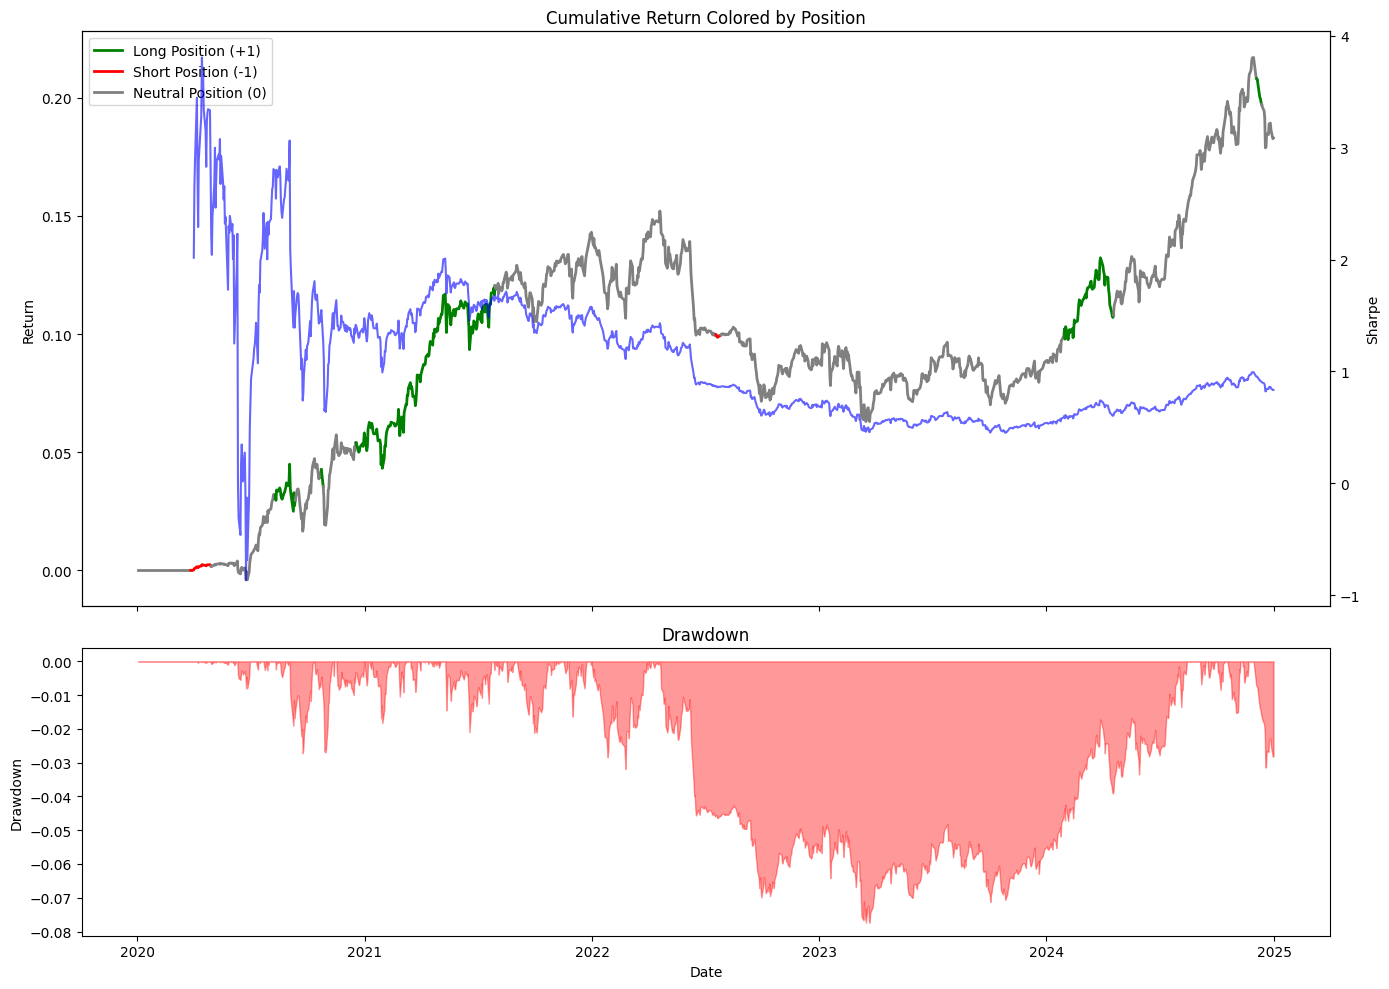

In [371]:
returns, _ = backtest_metrics_close_to_close(price_df, combined_weights)
plot_performance_with_signals(returns, signals)

In [207]:
def backtest_with_rebalancing(price_df, compute_combined_weights_fn, rebalance_freq=21, capital=100000, start_date=None, plot_progress=False):
    price_df = price_df.copy()
    price_df.index = pd.to_datetime(price_df.index)
    all_dates = sorted(price_df.index.unique())

    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        trading_dates = [d for d in all_dates if d >= start_date]
        pre_start_dates = [d for d in all_dates if d < start_date]
    else:
        trading_dates = all_dates
        pre_start_dates = []

    portfolio_value = capital
    portfolio_returns = []
    portfolio_dates = []
    last_rebalance_idx = 0
    current_weights = pd.Series(dtype=float)

    # Pre-start filler
    for d in pre_start_dates:
        portfolio_dates.append(d)
        portfolio_returns.append(0)

    if not trading_dates:
        raise ValueError("No trading dates available on or after start_date")

    # Initial weight load
    try:
        full_weights = compute_combined_weights_fn(price_df, trading_dates[0])
        current_weights = full_weights.loc[trading_dates[0]]
    except Exception as e:
        print(f"[ERROR] Failed initial weight computation: {e}")
        current_weights = pd.Series(dtype=float)

    # Main loop
    for i in range(1, len(trading_dates)):
        curr_date = trading_dates[i]

        # Rebalance
        if (i - last_rebalance_idx) >= rebalance_freq:
            rebalance_date = trading_dates[i - 1]
            try:
                full_weights = compute_combined_weights_fn(price_df, rebalance_date)
                current_weights = full_weights.loc[rebalance_date]
                last_rebalance_idx = i
            except Exception as e:
                print(f"[WARN] Failed rebalance at {rebalance_date.date()}: {e}")
                current_weights = pd.Series(dtype=float)

        # Skip if weights are empty
        if current_weights.empty:
            print(f"[SKIP] No weights on {curr_date.date()}")
            portfolio_dates.append(curr_date)
            portfolio_returns.append(0)
            continue

        try:
            close_prev = price_df.loc[trading_dates[i - 1]].set_index('Symbol')['Close']
            close_curr = price_df.loc[curr_date].set_index('Symbol')['Close']
            asset_returns = (close_curr / close_prev - 1).reindex(current_weights.index).fillna(0)
            port_return = (current_weights * asset_returns).sum()
        except Exception as e:
            print(f"[ERROR] Return calc failed on {curr_date.date()}: {e}")
            port_return = 0

        portfolio_value *= (1 + port_return)
        portfolio_returns.append(port_return)
        portfolio_dates.append(curr_date)

    # Final performance DF
    performance_df = pd.DataFrame({
        'Date': portfolio_dates,
        'Daily Return': portfolio_returns
    })
    performance_df['Cumulative Return'] = (1 + performance_df['Daily Return']).cumprod() - 1
    performance_df['Portfolio Value'] = capital * (1 + performance_df['Cumulative Return'])
    performance_df.set_index('Date', inplace=True)

    if plot_progress:
        plot_performance(performance_df['Daily Return'])

    return performance_df


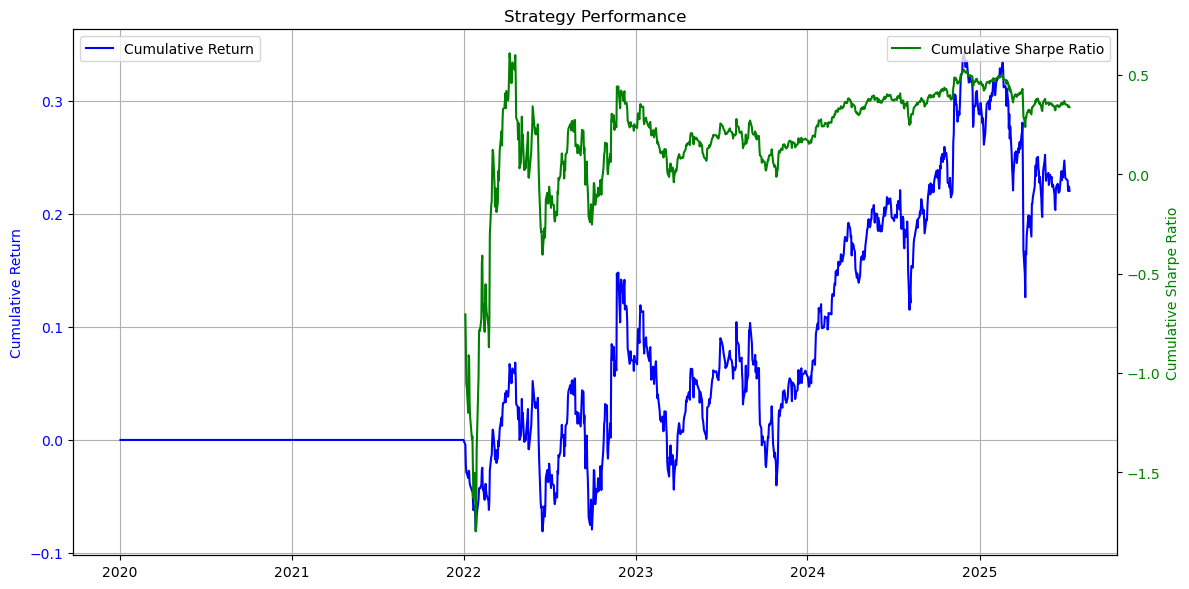

In [35]:
df = load_price_data()
performance_df = backtest_with_rebalancing(df, compute_combined_weights_for_date, rebalance_freq=21, capital=100_000, start_date='2022-01-01', plot_progress=True)

In [60]:
def backtest_close_to_close(
    price_df, combined_weights,
    initial_capital=1_000_000,
    base_drawdown_limit=-0.10,
    risk_sensitivity=0.5,
    reentry_threshold=0.90,
    kelly_lookback=60
):
    price_df = price_df.sort_index()
    all_dates = sorted(set(price_df.index.unique()) & set(combined_weights.index))

    portfolio_value = initial_capital
    running_max = initial_capital
    portfolio_values = [initial_capital]
    portfolio_returns = []
    portfolio_dates = []

    recent_returns = []
    stopped = False

    for i in range(1, len(all_dates)):
        prev_date = all_dates[i - 1]
        curr_date = all_dates[i]

        if not stopped:
            weights = combined_weights.loc[prev_date]
            close_prev = price_df.loc[prev_date].set_index('Symbol')['Close']
            close_curr = price_df.loc[curr_date].set_index('Symbol')['Close']
            asset_returns = (close_curr / close_prev - 1).reindex(weights.index).fillna(0)
            port_return = (weights * asset_returns).sum()
        else:
            port_return = 0.0

        # Calculate Kelly fraction using your external function
        if len(recent_returns) >= kelly_lookback:
            kelly_fraction = get_dynamic_kelly_fraction(np.array(recent_returns[-kelly_lookback:]))
        else:
            kelly_fraction = 0.0

        # Scale return by Kelly fraction if not stopped
        if stopped:
            port_return = 0.0
        else:
            port_return *= kelly_fraction

        # Update portfolio value
        portfolio_value *= (1 + port_return)
        running_max = max(running_max, portfolio_value)

        # Append latest return for Kelly calculation
        recent_returns.append(port_return)

        # Check stop loss using your external function
        stop_investing, adjusted_limit = check_stop_loss(
            portfolio_value, running_max, kelly_fraction,
            base_drawdown_limit=base_drawdown_limit,
            risk_sensitivity=risk_sensitivity
        )

        current_drawdown = (portfolio_value / running_max) - 1

        if stop_investing and not stopped:
            print(f"[STOP] {curr_date} - Drawdown {current_drawdown:.2%} exceeded limit {adjusted_limit:.2%}, halting trading.")
            stopped = True

        # Re-entry condition
        if stopped and portfolio_value >= reentry_threshold * running_max:
            print(f"[RE-ENTRY] {curr_date} - Portfolio recovered to {portfolio_value:.2f}, resuming trading.")
            stopped = False

        portfolio_dates.append(curr_date)
        portfolio_returns.append(port_return)
        portfolio_values.append(portfolio_value)

    return (
        pd.Series(portfolio_returns, index=portfolio_dates).sort_index(),
        pd.Series(portfolio_values[1:], index=portfolio_dates)
    )


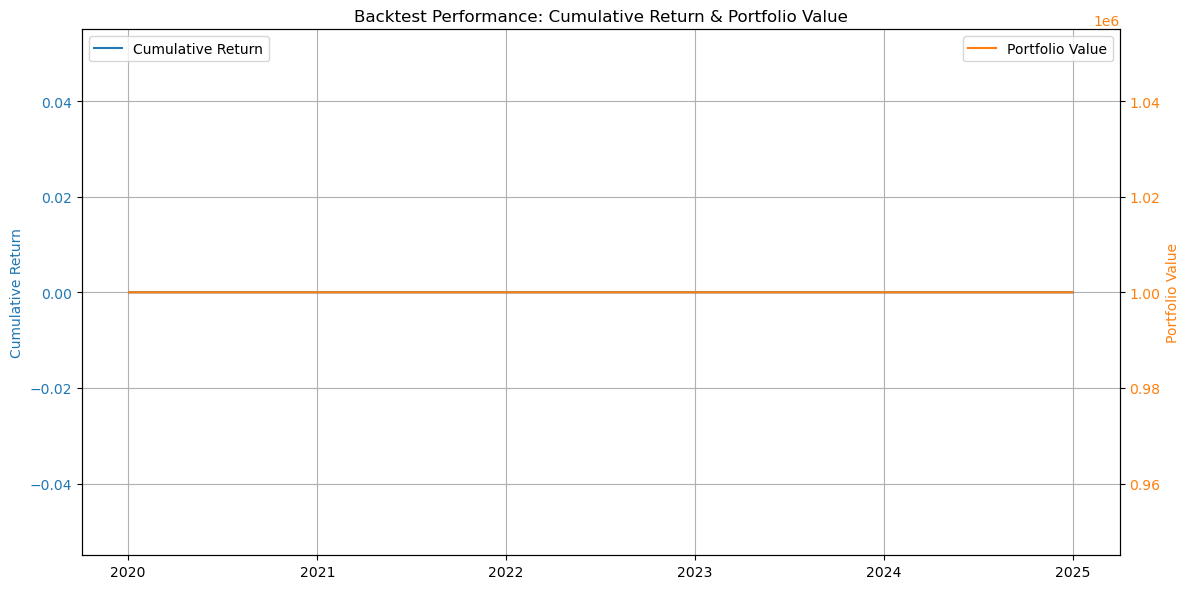

In [ ]:
returns, values = backtest_close_to_close(
    price_df, final_weights,
    initial_capital=1_000_000,
    base_drawdown_limit=-0.10,
    risk_sensitivity=0.5,
    reentry_threshold=0.70,
    kelly_lookback=60
)


OTHER FUNCTIONS

In [6]:
def apply_signal_mask(weights_df, signal_df):
    """
    Zero out weights for symbols not in the signal.

    Args:
        weights_df: DataFrame of raw weights (dates x tickers).
        signal_df: Binary DataFrame (dates x tickers), 1 = investable.

    Returns:
        masked_weights_df: Filtered weights with non-signal symbols zeroed.
    """
    # Align signal_df index to weights_df
    signal_df = signal_df.reindex_like(weights_df).fillna(0).astype(int)

    # Element-wise multiplication to apply the mask
    masked_weights_df = weights_df * signal_df

    # Re-normalize weights so each row sums to 1 (or 0 if all-zero)
    row_sums = masked_weights_df.sum(axis=1)
    normalized_weights = masked_weights_df.div(row_sums.replace(0, np.nan), axis=0).fillna(0)

    return normalized_weights

TRADE EXECUTION

In [216]:
def get_trade_entry_exit_dates(begin_new_trading_period=True, holding_period=None, entry_date=None):
    if not begin_new_trading_period:
        return None, None

    nyse = mcal.get_calendar('NYSE')
    today = datetime.today().date()

    # Parse entry_date
    if entry_date:
        if isinstance(entry_date, str):
            entry_date = datetime.strptime(entry_date, "%Y-%m-%d").date()
        elif isinstance(entry_date, datetime):
            entry_date = entry_date.date()
        elif not isinstance(entry_date, datetime.date):
            raise ValueError("entry_date must be a date, datetime, or YYYY-MM-DD string")
    else:
        entry_date = today

    # Get trading schedule
    days_to_add = 90 if holding_period is None else holding_period + 30
    schedule = nyse.schedule(start_date=entry_date, end_date=entry_date + timedelta(days=days_to_add))
    trading_days = list(schedule.index.date)

    # Adjust entry_date to next valid trading day
    next_entry_dates = [d for d in trading_days if d >= entry_date]
    if not next_entry_dates:
        raise ValueError("No valid trading days found after entry_date")
    entry_date = next_entry_dates[0]

    # If holding_period is not given, return only entry date
    if holding_period is None:
        return entry_date, None

    # Calculate exit date
    desired_exit_date = entry_date + timedelta(days=holding_period - 1)
    candidate_exit_days = [d for d in trading_days if entry_date <= d <= desired_exit_date]

    if candidate_exit_days:
        exit_date = candidate_exit_days[-1]
    else:
        exit_date = max([d for d in trading_days if d <= desired_exit_date], default=None)
        if exit_date is None:
            raise ValueError("No valid exit trading day found")

    return entry_date, exit_date

def get_previous_trading_day(date):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=date - timedelta(days=10), end_date=date)
    trading_days = list(schedule.index.date)
    for d in reversed(trading_days):
        if d < date:
            return pd.to_datetime(d)

def prepare_trade_allocation(entry_date, price_df, weights, capital=100_000):
    """
    Prepare trade allocations for the upcoming entry_date.
    Assumes this is run *after market close* on the day before entry_date.
    
    Args:
        entry_date (date): The date you plan to enter (buy) positions next market open.
        price_df (DataFrame): Price data with Date index and Symbols as columns (daily close).
        filtered_kelly_weights (DataFrame): Weights filtered and normalized by date and symbol.
        capital (float): Total capital to allocate.

    Returns:
        dict: {
            'entry_date': entry_date,
            'allocation_date': allocation_date,  # day before entry_date
            'weights': weights,
            'prices': entry_prices,
            'shares': shares,
            'capital_allocated': invested_capital
        }
    """
    allocation_date = get_previous_trading_day(entry_date)
    
    # Validate dates
    if allocation_date not in weights.index:
        raise ValueError(f"Allocation date {allocation_date} not found in filtered_kelly_weights")

    
    # Get weights from day before entry
    weights = weights.loc[allocation_date]
    weights = weights[weights > 0]  # only positive weights
    
    if weights.sum() == 0:
        raise ValueError(f"No positive weights on allocation date {allocation_date}")
    
    weights /= weights.sum()  # Normalize
    
    # Get prices on entry date (next open prices assumed equal to close previous day for simplicity)
    # You can replace with actual open prices if available
    entry_prices = price_df.loc[allocation_date, weights.index]
    
    # Calculate shares to buy (integer shares)
    shares = (capital * weights / entry_prices).fillna(0).astype(int)
    
    invested_capital = (shares * entry_prices).sum()
    
    data = pd.DataFrame({
        'entry_date': entry_date,
        'allocation_date': allocation_date,
        'shares': shares,
        'symbols': shares.index,
        'capital_allocated': invested_capital
    })
    
    data.to_csv('portfolio_allocation.csv',index=False)
    
    return entry_date, allocation_date, weights,entry_prices,shares,invested_capital


PORTFOLIO PERFORMANCE TRACKING

In [208]:
def track_portfolio_performance(
    price_df,
    entry_date,
    shares,
    invested_capital,
    log_path="portfolio_performance_log.csv",
    overwrite_log=False
):
    """
    Tracks daily portfolio performance from 7 days before entry_date to today.
    Avoids re-logging already tracked dates.

    Args:
        price_df (pd.DataFrame): Price data (index = Date, columns = Symbols).
        entry_date (datetime.date or str): Date when shares were bought.
        shares (pd.Series): Shares bought per symbol (index = symbol).
        invested_capital (float): Total capital spent.
        log_path (str): File path to save performance log.
        overwrite_log (bool): If True, deletes existing log and starts fresh.

    Returns:
        pd.DataFrame: Updated performance log.
    """
    # Ensure datetime handling
    price_df.index = pd.to_datetime(price_df.index)
    entry_date = pd.to_datetime(entry_date).date()
    start_date = entry_date - timedelta(days=20)
    today = datetime.today().date()

    # Filter trading dates
    trading_dates = sorted([d for d in price_df.index.date if start_date <= d <= today])
    if not trading_dates:
        raise ValueError("No valid trading dates in the specified range.")

    # Slice price data for relevant dates and symbols
    symbols = shares.index
    price_slice = price_df.loc[price_df.index.date >= start_date, symbols]
    price_slice = price_slice[price_slice.index.date <= today]

    portfolio_values = (price_slice * shares).sum(axis=1)

    daily_profit = portfolio_values.diff().fillna(0)  # $ change vs previous day
    cumulative_profit = portfolio_values - invested_capital  # $ total profit since entry

    daily_return = portfolio_values.pct_change().fillna(0)  # % change vs previous day
    cumulative_return = cumulative_profit / invested_capital  # total % return since entry
    
    performance_df = pd.DataFrame({
        "date": portfolio_values.index.date,
        "portfolio_value": portfolio_values.values,
        "daily_profit": daily_profit.values,
        "cumulative_profit": cumulative_profit.values,
        "daily_return": daily_return.values,
        "cumulative_return": cumulative_return.values
    })

    # Handle logging
    if overwrite_log and Path(log_path).exists():
        Path(log_path).unlink()

    if Path(log_path).exists():
        old_df = pd.read_csv(log_path, parse_dates=["date"])
        old_df["date"] = pd.to_datetime(old_df["date"]).dt.date

        # Avoid duplicate dates
        new_df = performance_df[~performance_df["date"].isin(old_df["date"])]
        performance_df = pd.concat([old_df, new_df], ignore_index=True)
        performance_df.sort_values("date", inplace=True)
        print(f"{len(new_df)} new rows logged.")
    else:
        print(f"{len(performance_df)} rows logged (new log).")

    # Save updated log
    performance_df.to_csv(log_path, index=False)
    print(f"Performance log updated. Last date: {performance_df['date'].max()}")
    
    return performance_df

PLOTTING

In [ ]:
def plot_portfolio_performance_with_entry_split(performance_df, entry_date):
    """
    Plot portfolio value over time, using a different color before and after entry_date.

    Args:
        performance_df (pd.DataFrame): DataFrame with 'date', 'portfolio_value', 'return_pct'.
        entry_date (datetime.date or str): Entry date to split the plot.
    """
    # Ensure datetime types
    performance_df['date'] = pd.to_datetime(performance_df['date'])
    entry_date = pd.to_datetime(entry_date)

    # Split data before and after entry
    before_entry = performance_df[performance_df['date'] < entry_date]
    after_entry = performance_df[performance_df['date'] >= entry_date]

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Plot pre-entry in gray
    plt.plot(before_entry['date'], before_entry['cumulative_profit'], color='gray', linestyle='--', label='Before Entry')

    # Plot post-entry in blue
    plt.plot(after_entry['date'], after_entry['cumulative_profit'], color='tab:blue', linewidth=2, label='After Entry')

    plt.axvline(entry_date, color='black', linestyle=':', linewidth=1)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rolling_sharpe_ratio(performance_df, window=1):
    """
    Plot rolling Sharpe ratio over time.

    Args:
        performance_df (pd.DataFrame): Must contain 'date' and 'daily_return'.
        window (int): Rolling window size in days.
        risk_free_rate_annual (float): Annualized risk-free rate (e.g., 0.05 for 5%).
    """
    # Ensure proper types
    performance_df['date'] = pd.to_datetime(performance_df['date'])
    performance_df = performance_df.sort_values('date')
    

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(performance_df['date'], performance_df['sharpe_ratio'], label='Sharpe', color='tab:green')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{window}-Day Rolling Sharpe Ratio Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [157]:
price_df = load_price_data()
kelly_weights = construct_kelly_portfolio(price_df, window=60)
momentum_scores, signals = ewma_momentum_signals(price_df)
filtered_kelly_weights = apply_signal_mask(kelly_weights, signals)
kelly_returns = backtest_portfolio_holding_period(filtered_kelly_weights, price_df, holding_period=20)
metrics = performance_metrics(kelly_returns)

In [159]:
entry_date, exit_date = get_trade_entry_exit_dates(begin_new_trading_period=True)
entry_date, allocation_date, weights,entry_prices,shares,invested_capital = prepare_trade_allocation(entry_date, price_df, filtered_kelly_weights, capital=100000)

In [160]:
performance_df = track_portfolio_performance(
    price_df=price_df,
    entry_date=entry_date,
    shares=shares,
    invested_capital=invested_capital
)

0 new rows logged.
Performance log updated. Last date: 2025-07-07


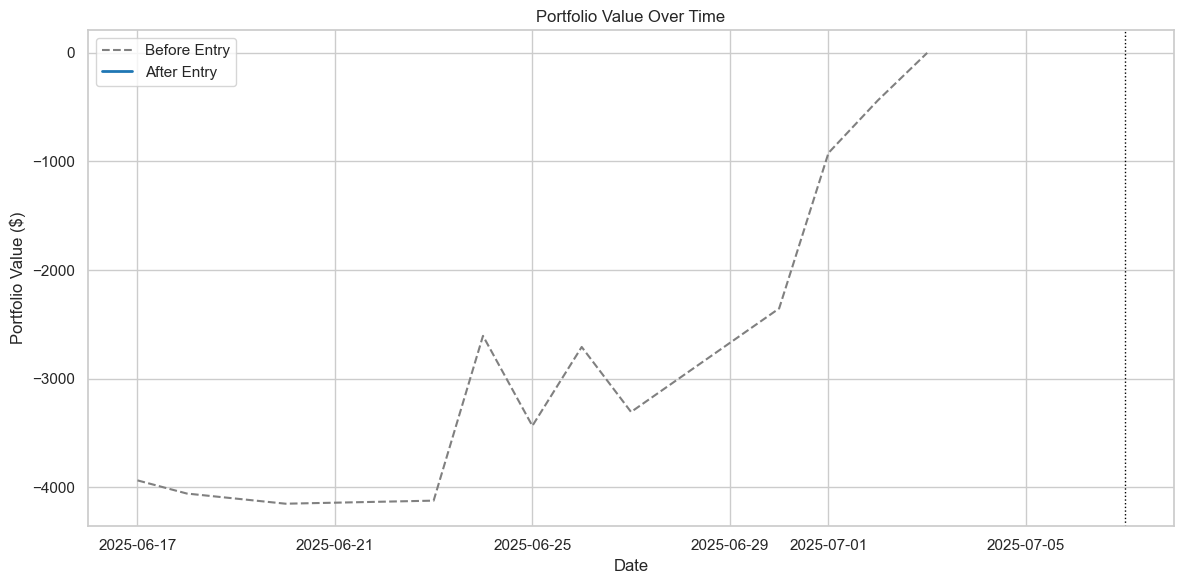

In [161]:
plot_portfolio_performance_with_entry_split(performance_df, entry_date)